# Задача 4.2
Рассмотрим некоторую задачу классификации. Пусть задано качество 4 моделей $a_1, a_2, a_3, a_4$. Качество полученных моделей показано в файле 
https://github.com/andriygav/PSAD/blob/master/labs/lab1/data/classifiers.csv 

Исследователю требуется выбрать наилучшую модель. Для выбора лучшей модели требуется попарно сравнить среднее значение качества всех моделей. Может ли исследователь утверждать что какая-то из моделей лучше другой?

**Требуется:**
1. Записать задачу формально.
2. Предложить статистику для решения данной задачи.
3. Записать нулевое распределение данной статистики.
4. Записать явно правило принятия решения на основе статистики и нулевого распределения для обеспечения уровня значимости $\alpha = 0.05$.
5. Проверить гипотезу по записанному критерию для данных из условия. Противоречат ли они гипотезе?

Все выкладки должны быть сделаны аналитически, без использования компьютера. Допускается использование компютера для подстановки

In [3]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns

In [4]:
data = pd.read_csv('https://raw.githubusercontent.com/andriygav/PSAD/master/labs/lab1/data/classifiers.csv', index_col='Номер выборки')
data

,a1,a2,a3,a4
Номер выборки,,,,
1,86,50,93,13
2,85,74,55,35
3,53,92,58,51
4,44,41,56,37
5,2,18,99,26
6,5,68,35,17


## ANOVA

Для начала запустим тест HSD Тьюки и проверим, какие средние совпадают, а какие нет.


$$ n = \frac{K}{\sum_{k=1}^K(1/n_k)}  $$
$$ S^2 = \frac{1}{N-K}\sum_{k=1}^K(n_k-1)(S_k)^2 $$

Где $S_k^{2} $- это дисперсия выборки $X_k^{n_k}$,
$$ HSD = \frac{q_\alpha(N-K)S}{\sqrt S}$$

$Где q_\alpha(N-K)$ - критическое значние распределения стьюдентизированного размаха с (N-K) степенями свободы.

Если $|\overline X_i - \overline X_j| > HSD$ , то частная нулевая гипотеза $H_0:\alpha_i = \alpha_j$ отклоняется против двусторонней альтернативы 

Между несовпадающими будем запускать односторонний критерий знаковых рангов

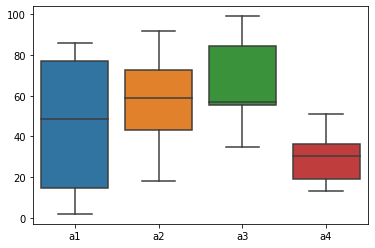

In [9]:
_ = sns.boxplot(data=data)

In [6]:
result_hsd = st.tukey_hsd(*np.array(data).T)
print(result_hsd)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)    -11.333     0.882   -54.550    31.884
 (0 - 2)    -20.167     0.570   -63.384    23.050
 (0 - 3)     16.000     0.731   -27.217    59.217
 (1 - 0)     11.333     0.882   -31.884    54.550
 (1 - 2)     -8.833     0.939   -52.050    34.384
 (1 - 3)     27.333     0.316   -15.884    70.550
 (2 - 0)     20.167     0.570   -23.050    63.384
 (2 - 1)      8.833     0.939   -34.384    52.050
 (2 - 3)     36.167     0.122    -7.050    79.384
 (3 - 0)    -16.000     0.731   -59.217    27.217
 (3 - 1)    -27.333     0.316   -70.550    15.884
 (3 - 2)    -36.167     0.122   -79.384     7.050



Статистика для теста Тьюки - это разница средних. Как можно видеть из результатов, статистики для пар (2 - x) наибольшие и всегда больше нуля, также они имеют наиболее сдвинутый в положительную часть доверительный интервал, из чего заключаем, что модель $2$ имеет наибольшее среднее

## Двухвыборочный критерий знаков

Также можем попарно прогнать двухвыборочный критерий знаков. Постановка задачи будет как в критерии знаков для проверки гипотезы о равенстве двух медиан.

выборки: $X_1^{n} = (X_{11}, \dots, X_{1n}), X_2^{n} = (X_{21}, \dots, X_{2n})  , X_{1i} \neq X_{2i}$

Выборки связанные

Нулевая гипотеза : $H_0 : P(X_1>X_2) = 1/2$

Альтернативная гипотеза : $H_1 : P(X_1>X_2) <\neq> 1/2$

Статистика : $T(X_1^{n},X_2^{n}) = \sum_{i=1}^n[X_{1i} > X_{2i}]$

Нулевое распределение : $Bin(n,1/2)$

Зафиксируем уровень значимости 0.05 и если по результатам теста альтернатива будет отклонена, смотрим на статистику. Статистика больше нуля - значит, $med \ X_1 > med \ X_2$, иначе - меньше. Так мы сможем отсортировать модели по медиане и определить наилучшую на данном уровне значимости.

In [5]:
import itertools
from statsmodels.stats.descriptivestats import sign_test

arr = ['a1', 'a2', 'a3', 'a4']

for c1, c2 in itertools.product(arr, arr):
    if c1 != c2:
        stat, p = sign_test(data[c1] - data[c2])
        if p < 0.05:
            print(c1, c2, stat, p)

a3 a4 3.0 0.03125
a4 a3 -3.0 0.03125


ВЫВОД : В данном случае можем сказать только то, что модель $3$ работает лучше, чем модель $4$ на уровне значимости 0.05. Про другие модели на данном уровне значимости не можем делать выводы.